# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
# from sklearn.model_selection import train_test_split
import tensorflow as tf
# import tensorflow.compat.v2.feature_column as fc

from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output
from six.moves import urllib

**Checking tensorflow version**

In [2]:
tf.__version__

'2.8.2'

# Linear Regression

## Data

In [3]:
train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train.pop('survived')
y_eval = eval.pop('survived')

In [4]:
print(train.head())
print(y_train.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [5]:
train.describe(), train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


(              age  n_siblings_spouses       parch        fare
 count  627.000000          627.000000  627.000000  627.000000
 mean    29.631308            0.545455    0.379585   34.385399
 std     12.511818            1.151090    0.792999   54.597730
 min      0.750000            0.000000    0.000000    0.000000
 25%     23.000000            0.000000    0.000000    7.895800
 50%     28.000000            0.000000    0.000000   15.045800
 75%     35.000000            1.000000    0.000000   31.387500
 max     80.000000            8.000000    5.000000  512.329200, None)

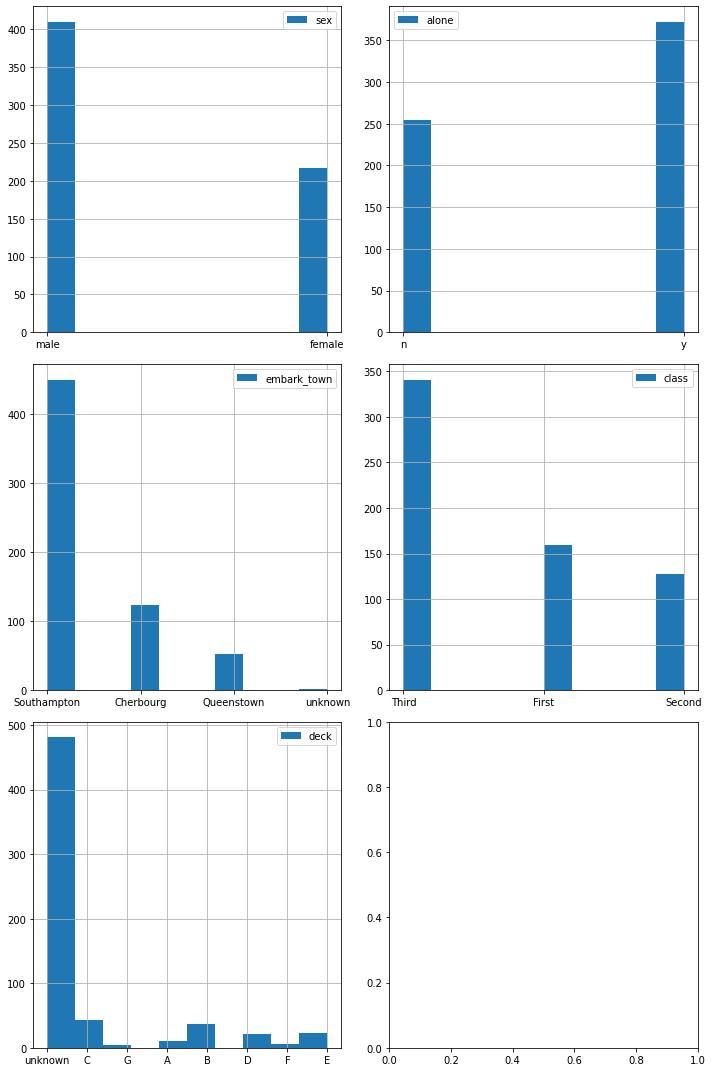

In [6]:
figure, axes = plt.subplots(3, 2, figsize=(10, 15))

train['sex'].hist(ax=axes[0,0], legend=True)
train['alone'].hist(ax=axes[0,1], legend=True)
train['embark_town'].hist(ax=axes[1,0], legend=True)
train['class'].hist(ax=axes[1,1], legend=True)
train['deck'].hist(ax=axes[2,0], legend=True)

plt.tight_layout()
plt.show()

## Create feature columns

In [7]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [8]:
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name))

In [9]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

## The Training Process

**Input function**

In [10]:
def make_input_fn(data, label, num_epochs=10, shuffle=True, batch_size=32):
  '''
  data:   input data (pandas dataframe)
  label:  label of the data (pandas dataframe)
  rest of the parameters are pretty much self-explanatory
  '''
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data), label))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [11]:
train_input_fn = make_input_fn(train, y_train, num_epochs=20, batch_size=64)
eval_input_fn = make_input_fn(eval, y_eval, num_epochs=1, shuffle=False)

**Creating the model**

In [12]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4phico9a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


**Training the model**

In [13]:
linear_est.train(train_input_fn)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4phico9a/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 295.925
INFO:tensorflow:loss = 0.41675717, step = 100 (0.342 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp4phico9a/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for final step: 0.5896701.


## Evaluation and Prediction

**Evaluating the model**

In [14]:
result = linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-06-26T18:24:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4phico9a/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.62906s
INFO:tensorflow:Finished evaluation at 2022-06-26-18:24:26
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.75757575, accuracy_baseline = 0.625, auc = 0.83336395, auc_precision_recall = 0.79091585, average_loss = 0.47301415, global_step = 200, label/mean = 0.375, loss = 0.46448913, precision = 0.68817204, prediction/mean = 0.3685578, recall = 0.64646465
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmp4phico9a/model.ckpt-200


In [15]:
result

{'accuracy': 0.75757575,
 'accuracy_baseline': 0.625,
 'auc': 0.83336395,
 'auc_precision_recall': 0.79091585,
 'average_loss': 0.47301415,
 'global_step': 200,
 'label/mean': 0.375,
 'loss': 0.46448913,
 'precision': 0.68817204,
 'prediction/mean': 0.3685578,
 'recall': 0.64646465}

**Make predictions**

In [16]:
predictions = list(linear_est.predict(eval_input_fn))

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4phico9a/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [17]:
predictions[0]

{'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'logistic': array([0.07217544], dtype=float32),
 'logits': array([-2.5537424], dtype=float32),
 'probabilities': array([0.9278245 , 0.07217547], dtype=float32)}

In [18]:
print(eval.iloc[15])
print(y_eval.iloc[15])
print(predictions[15]['probabilities']) # the second item in the output list denotes the probability that the person survived

sex                        female
age                          16.0
n_siblings_spouses              5
parch                           2
fare                         46.9
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 15, dtype: object
0
[0.4817449 0.5182551]


# Classification

## Data

### load the data

In [ ]:
data = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv')

### take a look into the data

In [ ]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ef71c9b10>,
      dtype=object)

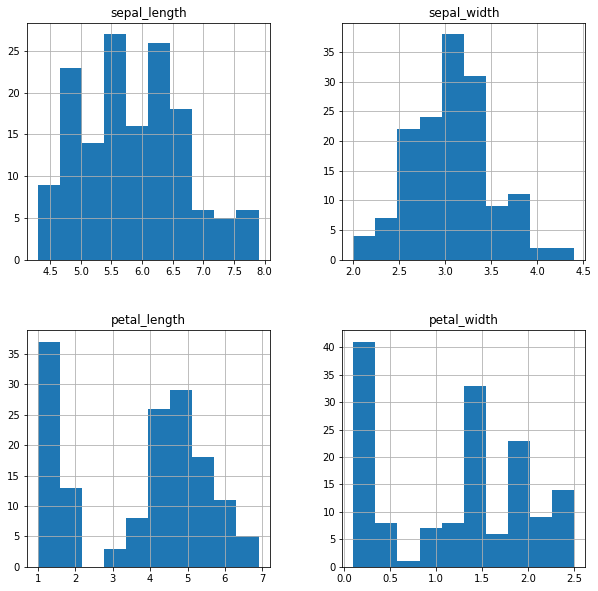

In [ ]:
data.hist(figsize=(10,10))

### split the data

In [ ]:
labels = data.pop('species')

In [ ]:
temp = list(labels.unique())
c = 0
mapper = {}

for flower_class in temp:
  mapper[flower_class] = c
  c += 1

labels.replace(mapper, inplace=True)
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [ ]:
y_test.head()

8      0
39     0
148    2
132    2
124    2
Name: species, dtype: int64

## Input function

In [ ]:
def input_fn(features, labels, shuffle=True, batch_size=256):
  dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
  if shuffle:
    dataset = dataset.shuffle(1000).repeat()
  return dataset.batch(batch_size)

## Feature Columns

In [ ]:
feature_columns = []

for feature_column in x_train.keys():
  feature_columns.append(tf.feature_column.numeric_column(key=feature_column))

In [ ]:
feature_columns

[NumericColumn(key='sepal_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='sepal_width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='petal_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='petal_width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

## Building the model

In [ ]:
classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [16, 32, 16, 8],
    n_classes = len(labels.unique())
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4lvo4t3f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training the  model

In [ ]:
classifier.train(input_fn=lambda: input_fn(x_train, y_train),
                 steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4lvo4t3f/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.1201873, step = 0
INFO:tensorflow:global_step/sec: 410.364
INFO:tensorflow:loss = 1.0613103, step = 100 (0.245 sec)
INFO:tensorflow:global_step/sec: 530.745
INFO:tensorflow:loss = 1.0332694, step = 200 (0.188 sec)
INFO:tensorflow:global_step/sec: 558.57
INFO:tensorflow:loss = 0.9913945, step = 300 (0.182 sec)
INFO:tensorflow:global_step/sec: 541.537
INFO:tensorflow:loss = 0.97874856, step = 400 (0.187 sec)
INFO:tensorflow:global_step/sec: 519.531
INFO:tensorflow:loss = 0.9597773, step = 500 (0.188 sec)
INFO:t

## Evaluation and Prediction

In [ ]:
classifier.evaluate(input_fn=lambda: input_fn(x_test, y_test, shuffle=False))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-01T17:43:36Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4lvo4t3f/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.24869s
INFO:tensorflow:Finished evaluation at 2021-03-01-17:43:36
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9, average_loss = 0.48955262, global_step = 5000, loss = 0.48955262
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp4lvo4t3f/model.ckpt-5000


{'accuracy': 0.9,
 'average_loss': 0.48955262,
 'global_step': 5000,
 'loss': 0.48955262}

In [ ]:
def test_input_fn(features, batch_size=128):
  return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [ ]:
predictions = classifier.predict(input_fn=lambda: test_input_fn(x_test))

In [ ]:
for prediction in predictions:
  print(prediction['probabilities'])
  # print(type(prediction))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4lvo4t3f/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0.57081807 0.21898304 0.2101989 ]
[0.5931269  0.20752043 0.19935273]
[0.00500547 0.11491055 0.88008404]
[0.0019654  0.07739491 0.92063963]
[0.00393311 0.13796665 0.8581003 ]
[0.0394733  0.7040787  0.25644806]
[0.00505297 0.28030193 0.714645  ]
[0.02166763 0.557258   0.42107433]
[0.02896002 0.67152745 0.2995125 ]
[0.03004596 0.7559327  0.21402135]
[0.59430796 0.20721523 0.19847682]
[0.5893245  0.20470865 0.20596689]
[0.59335506 0.20468965 0.20195521]
[0.01654278 0.3293008  0.6541563 ]
[0.00920888 0.5342777  0.45651352]
[0.02081959 0.599248   0.37993237]
[0.5985033  0.20206288 0.1994338 ]
[0.58324516 0.20007098 0.21668386]
[0.56715506 0.23274438 0.20010053]
[0.58870804 0.19830781 0.21298419]
[0.56733805 0.23781    0.1948519

# Hidden Markov Model

In [ ]:
import tensorflow_probability as tfp

## Weather Model

In [ ]:
tfd = tfp.distributions

In [ ]:
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.],
                                      scale=[5., 10.])

In [ ]:
model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7
)

In [ ]:
mean = model.mean()

In [ ]:
with tf.compat.v1.Session() as session:
  print(mean.numpy())

[2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]
